In [1]:
# Create a scatter plot of citations vs publication year with DataWrapper

import pandas as pd

# Load data
df = pd.read_csv("nobel_with_citations_cleaned.csv")

# Ensure numeric fields
df["Pub year"] = pd.to_numeric(df["Pub year"], errors="coerce")
df["Total Citations"] = pd.to_numeric(df["Total Citations"], errors="coerce")

# Drop missing pub year or citation count
df = df.dropna(subset=["Pub year", "Total Citations"])

# Drop zero-citation papers
df = df[df["Total Citations"] > 0]

# Drop duplicate papers (Resolved_WID preferred if available, else Title)
df = df.drop_duplicates(subset="Resolved_WID")


# Round pub year to int
df["Pub year"] = df["Pub year"].astype(int)

# Select columns for plotting
df_scatter = df[["Title", "Laureate name", "Pub year", "Total Citations"]]

# Save for Datawrapper
df_scatter.to_csv("scatter_citations_vs_pubyear_cleaned.csv", index=False)

# Preview
print(df_scatter.head())


                                               Title        Laureate name  \
2  Ueber Kathodenstrahlen in Gasen von atmosphris...            lenard, p   
3                                   XL. Cathode Rays  joseph john thomson   
4  On the Relative Motion of the Earth and the Lu...  albert a. michelson   
5  lxxxiv the radioactivity of thorium compounds ...        rutherford, e   
9  viii on the experimental surgery of the thorac...            carrel, a   

   Pub year  Total Citations  
2      1894             53.0  
3      1897            576.0  
4      1887           1392.0  
5      1902             52.0  
9      1910            297.0  


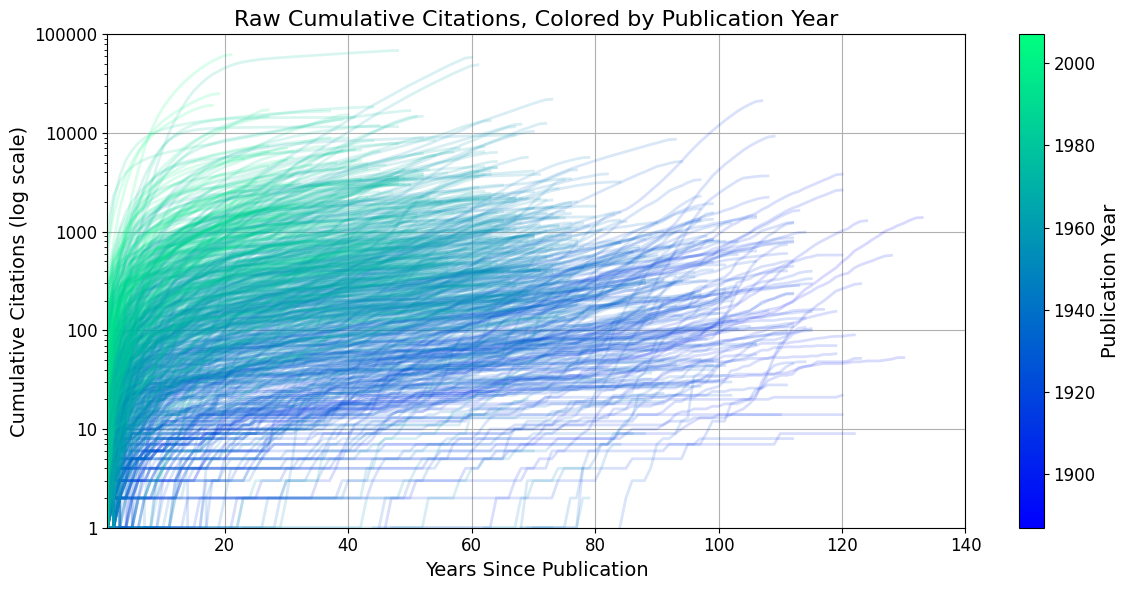

In [2]:
# Create a line plot of cumulative citations over time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

# Load and deduplicate
df = pd.read_csv("nobel_with_citations_cleaned.csv")
df = df.drop_duplicates(subset="Resolved_WID")

# Identify year columns
year_columns = sorted([col for col in df.columns if col.isdigit()], key=int)

# Filter papers with citation data
df["has_citation_data"] = df[year_columns].sum(axis=1) > 0
df_cited = df[df["has_citation_data"]].copy()

# Ensure publication year is numeric
df_cited["Pub year"] = pd.to_numeric(df_cited["Pub year"], errors="coerce")
pub_years = df_cited["Pub year"].fillna(df_cited["Pub year"].median())

# Color mapping: use modern syntax for colormaps
norm = mcolors.Normalize(vmin=pub_years.min(), vmax=2007)
cmap = plt.colormaps["winter"]  # avoids deprecation warning

# Storage
shifted_citations = []
colors = []
paper_ids = []

# Align citations by publication year (year 0 = Pub year)
for i, row in df_cited.iterrows():
    pub_year = row["Pub year"]
    if pd.isna(pub_year):
        continue

    citation_series = row[year_columns].copy()
    pub_year = int(pub_year)
    years = [int(y) for y in citation_series.index]
    valid_years = [str(y) for y in years if y >= pub_year]

    if len(valid_years) < 2:
        continue

    # Apply fillna after converting to float to avoid warning
    full_series = citation_series[valid_years].astype(float).fillna(0)
    cumulative = full_series.cumsum().values
    rel_years = np.arange(len(cumulative))

    shifted_citations.append(pd.Series(cumulative, index=rel_years))
    colors.append(cmap(norm(pub_year)))
    paper_ids.append(i)

# Build aligned DataFrame
aligned_df = pd.DataFrame(shifted_citations, index=paper_ids).T.sort_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
for col, color in zip(aligned_df.columns, colors):
    ax.plot(aligned_df.index, aligned_df[col], alpha=0.15, color=color, linewidth=2)

# Log scale on Y-axis
#ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Years Since Publication", fontsize=14)
ax.set_ylabel("Cumulative Citations (log scale)", fontsize=14)
ax.set_title("Raw Cumulative Citations, Colored by Publication Year", fontsize=16)
ax.grid(True)
ax.set_xlim(1,140)
ax.set_ylim(1, 10**5)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
ax.ticklabel_format(style='plain', axis='y')  # disable scientific notation for y-axis
ax.tick_params(axis='both', labelsize=12)  # or any size you prefer

# Add colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Publication Year", fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

# Save high res figure
fig.savefig("cumulative_citations_by_year.png", dpi=300, bbox_inches='tight')


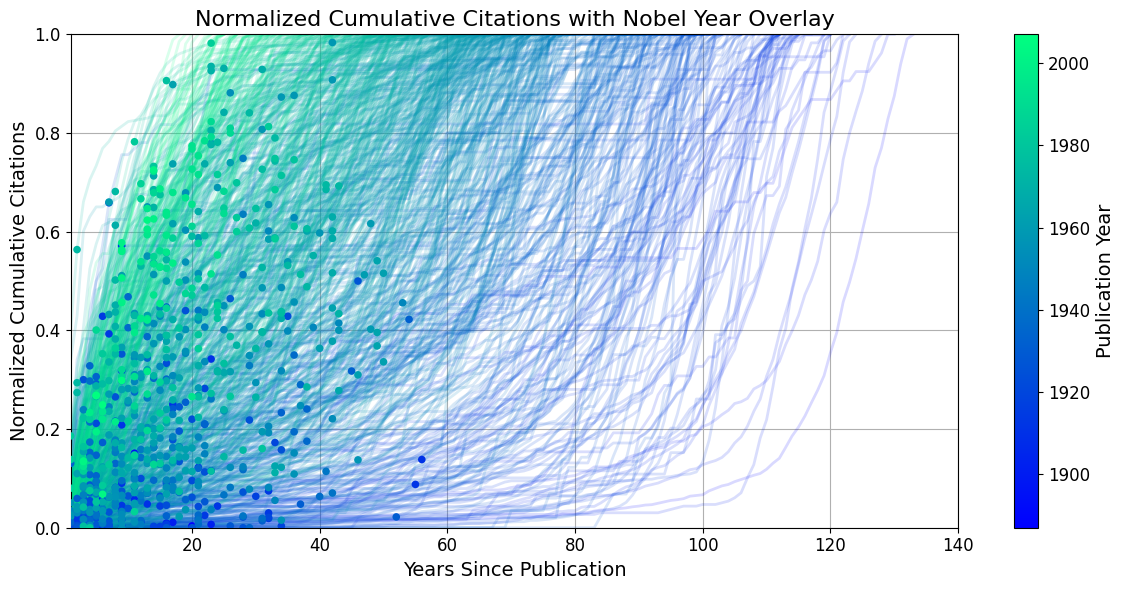

In [3]:
# Create a line plot of normalized cumulative citations over time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Load and deduplicate
df = pd.read_csv("nobel_with_citations_cleaned.csv")
df = df.drop_duplicates(subset="Resolved_WID")
df = df[pd.to_numeric(df["Total Citations"], errors="coerce") > 10].copy()

# Identify citation year columns
year_columns = sorted([col for col in df.columns if col.isdigit()], key=int)
df_cited = df[df[year_columns].sum(axis=1) > 0].copy()

# Ensure year fields are numeric
df_cited["Pub year"] = pd.to_numeric(df_cited["Pub year"], errors="coerce")
df_cited["Prize year"] = pd.to_numeric(df_cited["Prize year"], errors="coerce")
pub_years = df_cited["Pub year"].fillna(df_cited["Pub year"].median())

# Color mapping: winter colormap by publication year
norm = mcolors.Normalize(vmin=pub_years.min(), vmax=2007)
cmap = plt.colormaps["winter"]

# Storage
shifted_citations = []
colors = []
nobel_dots = []

# Align citations by publication year
for i, row in df_cited.iterrows():
    pub_year = row["Pub year"]
    prize_year = row["Prize year"]

    if pd.isna(pub_year) or pd.isna(prize_year):
        continue

    citation_series = row[year_columns].copy()
    pub_year = int(pub_year)
    prize_year = int(prize_year)
    years = [int(y) for y in citation_series.index]
    valid_years = [str(y) for y in years if y >= pub_year]

    if len(valid_years) < 2:
        continue

    full_series = citation_series[valid_years].astype(float).fillna(0)
    cumulative = full_series.cumsum()
    total = cumulative.iloc[-1] if cumulative.iloc[-1] > 0 else 1
    cumulative = (cumulative / total).values
    rel_years = np.arange(len(cumulative))

    trace = pd.Series(cumulative, index=rel_years)
    shifted_citations.append(trace)
    color = cmap(norm(pub_year))
    colors.append(color)

    # Calculate x = prize_year - pub_year for dot
    prize_offset = prize_year - pub_year
    if prize_offset in trace.index:
        nobel_dots.append((prize_offset, trace.loc[prize_offset], color))

# Build aligned DataFrame
aligned_df = pd.DataFrame(shifted_citations).T.sort_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
for col, color in zip(aligned_df.columns, colors):
    ax.plot(aligned_df.index, aligned_df[col], alpha=0.15, color=color, linewidth=2)

# Overlay Nobel prize dots
for x, y, color in nobel_dots:
    ax.scatter(x, y, color=color, s=30, edgecolor="none", zorder=5)

# Linear Y-axis (because values are now between 0 and 1)
ax.set_xlabel("Years Since Publication", fontsize=14)
ax.set_ylabel("Normalized Cumulative Citations", fontsize=14)
ax.set_title("Normalized Cumulative Citations with Nobel Year Overlay", fontsize=16)
ax.grid(True)
ax.set_xlim(1, 140)
ax.set_ylim(0, 1)
ax.tick_params(axis='both', labelsize=12)  # or any size you prefer

# Add colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Publication Year", fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

# Save high res figure
fig.savefig("normalized_cumulative_citations_by_year.png", dpi=300, bbox_inches='tight')


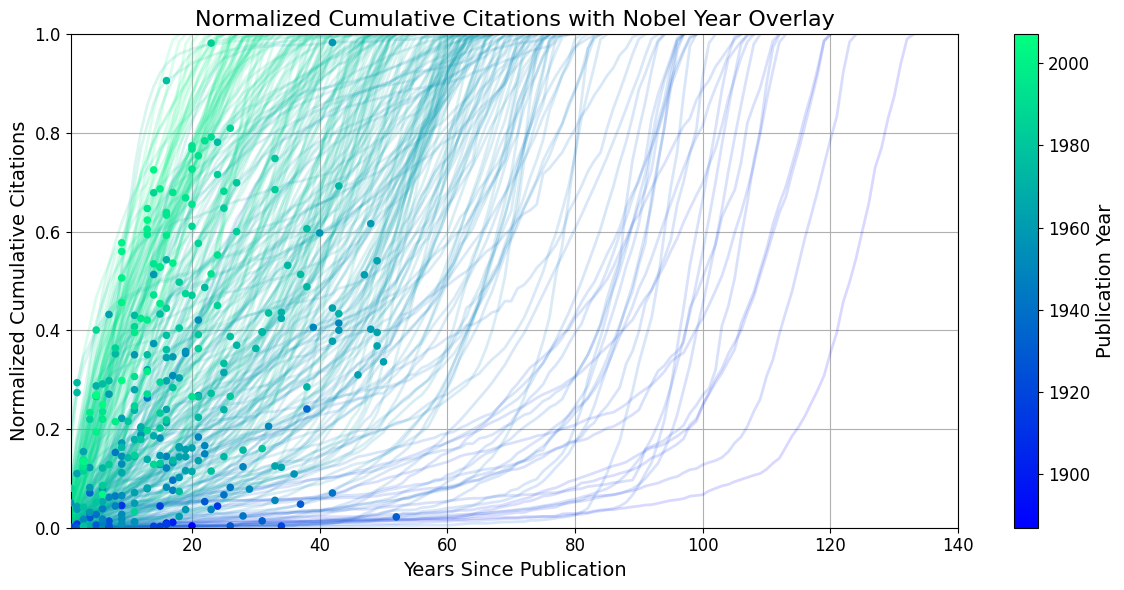

In [4]:
# Create a line plot of normalized cumulative citations over time for papers with >1000 citations

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Load and deduplicate
df = pd.read_csv("nobel_with_citations_cleaned.csv")
df = df.drop_duplicates(subset="Resolved_WID")
df = df[pd.to_numeric(df["Total Citations"], errors="coerce") > 1000].copy()

# Identify citation year columns
year_columns = sorted([col for col in df.columns if col.isdigit()], key=int)
df_cited = df[df[year_columns].sum(axis=1) > 0].copy()

# Ensure year fields are numeric
df_cited["Pub year"] = pd.to_numeric(df_cited["Pub year"], errors="coerce")
df_cited["Prize year"] = pd.to_numeric(df_cited["Prize year"], errors="coerce")
pub_years = df_cited["Pub year"].fillna(df_cited["Pub year"].median())

# Color mapping: winter colormap by publication year
norm = mcolors.Normalize(vmin=pub_years.min(), vmax=2007)
cmap = plt.colormaps["winter"]

# Storage
shifted_citations = []
colors = []
nobel_dots = []

# Align citations by publication year
for i, row in df_cited.iterrows():
    pub_year = row["Pub year"]
    prize_year = row["Prize year"]

    if pd.isna(pub_year) or pd.isna(prize_year):
        continue

    citation_series = row[year_columns].copy()
    pub_year = int(pub_year)
    prize_year = int(prize_year)
    years = [int(y) for y in citation_series.index]
    valid_years = [str(y) for y in years if y >= pub_year]

    if len(valid_years) < 2:
        continue

    full_series = citation_series[valid_years].astype(float).fillna(0)
    cumulative = full_series.cumsum()
    total = cumulative.iloc[-1] if cumulative.iloc[-1] > 0 else 1
    cumulative = (cumulative / total).values
    rel_years = np.arange(len(cumulative))

    trace = pd.Series(cumulative, index=rel_years)
    shifted_citations.append(trace)
    color = cmap(norm(pub_year))
    colors.append(color)

    # Calculate x = prize_year - pub_year for dot
    prize_offset = prize_year - pub_year
    if prize_offset in trace.index:
        nobel_dots.append((prize_offset, trace.loc[prize_offset], color))

# Build aligned DataFrame
aligned_df = pd.DataFrame(shifted_citations).T.sort_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
for col, color in zip(aligned_df.columns, colors):
    ax.plot(aligned_df.index, aligned_df[col], alpha=0.15, color=color, linewidth=2)

# Overlay Nobel prize dots
for x, y, color in nobel_dots:
    ax.scatter(x, y, color=color, s=30, edgecolor="none", zorder=5)

# Linear Y-axis (because values are now between 0 and 1)
ax.set_xlabel("Years Since Publication", fontsize=14)
ax.set_ylabel("Normalized Cumulative Citations", fontsize=14)
ax.set_title("Normalized Cumulative Citations with Nobel Year Overlay", fontsize=16)
ax.grid(True)
ax.set_xlim(1, 140)
ax.set_ylim(0, 1)
ax.tick_params(axis='both', labelsize=12)  # or any size you prefer

# Add colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Publication Year", fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

# Save high res figure
fig.savefig("normalized_cumulative_citations_by_year_1000.png", dpi=300, bbox_inches='tight')


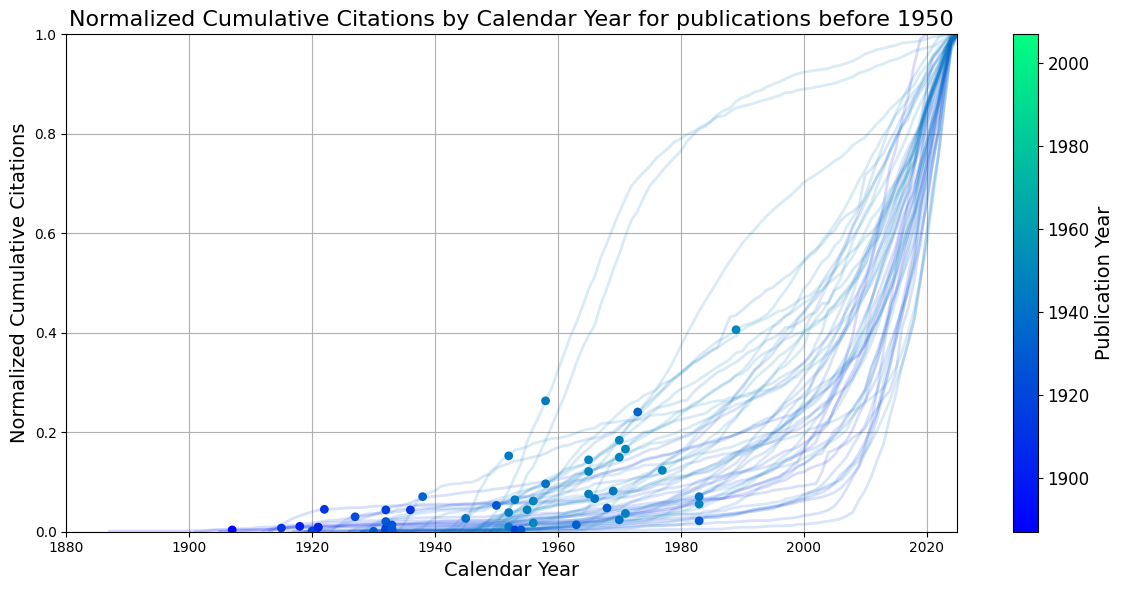

In [5]:
# Create a line plot of normalized cumulative citations over time for publications before 1950

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Load and deduplicate
df = pd.read_csv("nobel_with_citations_cleaned.csv")
df = df.drop_duplicates(subset="Resolved_WID")
df = df[pd.to_numeric(df["Total Citations"], errors="coerce") > 1000].copy()

# Only take publications before 1970
df = df[df["Pub year"] <= 1950]

# Identify citation year columns
year_columns = sorted([col for col in df.columns if col.isdigit()], key=int)
df_cited = df[df[year_columns].sum(axis=1) > 0].copy()

# Ensure year fields are numeric
df_cited["Pub year"] = pd.to_numeric(df_cited["Pub year"], errors="coerce")
df_cited["Prize year"] = pd.to_numeric(df_cited["Prize year"], errors="coerce")
pub_years = df_cited["Pub year"].fillna(df_cited["Pub year"].median())

# Color mapping: winter colormap by publication year
norm = mcolors.Normalize(vmin=pub_years.min(), vmax=2007)
cmap = plt.colormaps["winter"]

# Storage
shifted_citations = []
colors = []
nobel_dots = []

# Align by actual publication year
for i, row in df_cited.iterrows():
    pub_year = row["Pub year"]
    prize_year = row["Prize year"]

    if pd.isna(pub_year) or pd.isna(prize_year):
        continue

    citation_series = row[year_columns].copy()
    pub_year = int(pub_year)
    prize_year = int(prize_year)
    years = [int(y) for y in citation_series.index]
    valid_years = [str(y) for y in years if y >= pub_year]

    if len(valid_years) < 2:
        continue

    full_series = citation_series[valid_years].astype(float).fillna(0)
    cumulative = full_series.cumsum()
    total = cumulative.iloc[-1] if cumulative.iloc[-1] > 0 else 1
    cumulative = (cumulative / total).values
    rel_years = np.arange(pub_year, pub_year + len(cumulative))  # <— real years

    trace = pd.Series(cumulative, index=rel_years)
    shifted_citations.append(trace)
    color = cmap(norm(pub_year))
    colors.append(color)

    if prize_year in trace.index:
        nobel_dots.append((prize_year, trace.loc[prize_year], color))

# Build aligned DataFrame
aligned_df = pd.DataFrame(shifted_citations).T.sort_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
for col, color in zip(aligned_df.columns, colors):
    ax.plot(aligned_df.index, aligned_df[col], alpha=0.15, color=color, linewidth=2)

# Overlay Nobel prize dots
for x, y, color in nobel_dots:
    ax.scatter(x, y, color=color, s=40, edgecolor="none", zorder=5)

# Axis labels and formatting
ax.set_xlabel("Calendar Year", fontsize=14)
ax.set_ylabel("Normalized Cumulative Citations", fontsize=14)
ax.set_title("Normalized Cumulative Citations by Calendar Year for publications before 1950", fontsize=16)
ax.grid(True)
ax.set_xlim(1880, 2025)
ax.set_ylim(0, 1)

# Add colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Publication Year", fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

# Save high res figure
fig.savefig("normalized_cumulative_citations_by_year_1950.png", dpi=300, bbox_inches='tight')


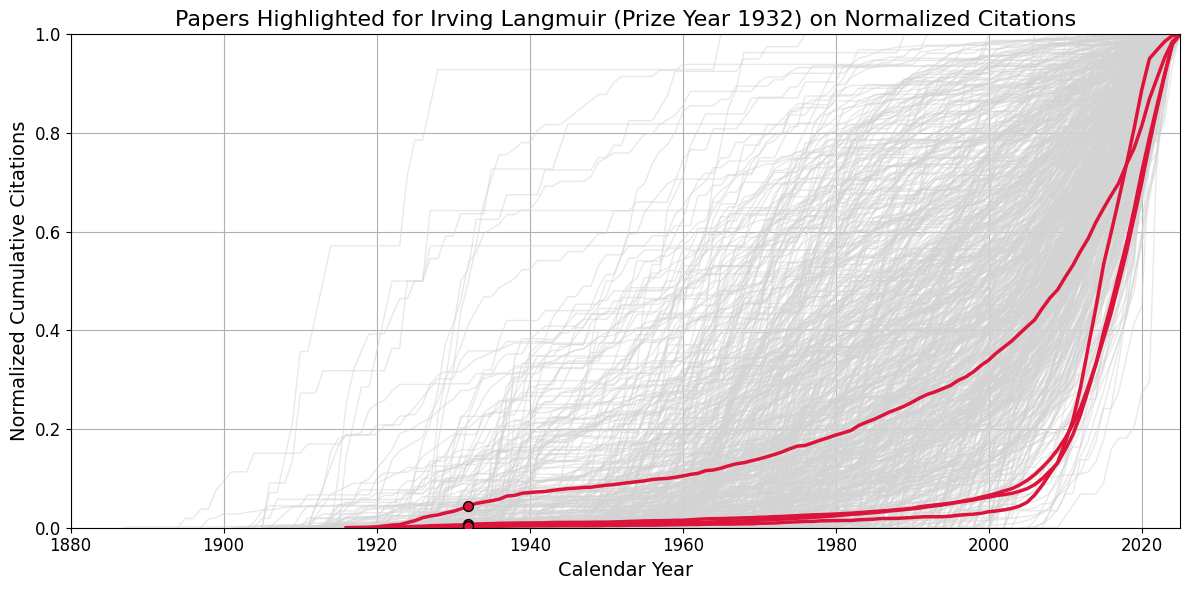

In [6]:
# Pick out Langmuir's 1932 Nobel Prize winning papers

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load and deduplicate
df = pd.read_csv("nobel_with_citations_cleaned.csv")
df = df.drop_duplicates(subset="Resolved_WID")
df = df[pd.to_numeric(df["Total Citations"], errors="coerce") > 10].copy()

# Identify citation year columns
year_columns = sorted([col for col in df.columns if col.isdigit()], key=int)
df_cited = df[df[year_columns].sum(axis=1) > 0].copy()

# Ensure year fields are numeric
df_cited["Pub year"] = pd.to_numeric(df_cited["Pub year"], errors="coerce")
df_cited["Prize year"] = pd.to_numeric(df_cited["Prize year"], errors="coerce")

# Langmuir filter
langmuir_year = 1932
langmuir_name = "langmuir, i"

# Storage
shifted_citations = []
highlight_traces = []
langmuir_dots = []

# Build traces
for i, row in df_cited.iterrows():
    pub_year = row["Pub year"]
    prize_year = row["Prize year"]

    if pd.isna(pub_year) or pd.isna(prize_year):
        continue

    citation_series = row[year_columns].copy()
    pub_year = int(pub_year)
    prize_year = int(prize_year)
    valid_years = [str(y) for y in year_columns if int(y) >= pub_year]

    if len(valid_years) < 2:
        continue

    full_series = citation_series[valid_years].astype(float).fillna(0)
    cumulative = full_series.cumsum()
    total = cumulative.iloc[-1] if cumulative.iloc[-1] > 0 else 1
    cumulative = (cumulative / total).values
    rel_years = np.arange(pub_year, pub_year + len(cumulative))  # ← actual calendar years

    trace = pd.Series(cumulative, index=rel_years)

    is_langmuir = (
        prize_year == langmuir_year and
        langmuir_name.lower() in str(row["Laureate name"]).lower()
    )

    if is_langmuir:
        highlight_traces.append(trace)
        if prize_year in trace.index:
            langmuir_dots.append((prize_year, trace.loc[prize_year]))
    else:
        shifted_citations.append(trace)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot background traces
for trace in shifted_citations:
    ax.plot(trace.index, trace.values, color="lightgray", alpha=0.5, linewidth=1)

# Highlight Langmuir traces
for trace in highlight_traces:
    ax.plot(trace.index, trace.values, color="crimson", linewidth=2.5, label="Langmuir (1932)")

# Overlay dots at prize year
for x, y in langmuir_dots:
    ax.scatter(x, y, color="crimson", edgecolor="black", s=50, zorder=5)

# Axis labels and formatting
ax.set_xlabel("Calendar Year", fontsize=14)
ax.set_ylabel("Normalized Cumulative Citations", fontsize=14)
ax.set_title("Papers Highlighted for Irving Langmuir (Prize Year 1932) on Normalized Citations", fontsize=16)
ax.grid(True)
ax.set_xlim(1880, 2025)
ax.set_ylim(0, 1)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

# Save high res figure
fig.savefig("langmuir_highlighted_citations.png", dpi=300, bbox_inches='tight')


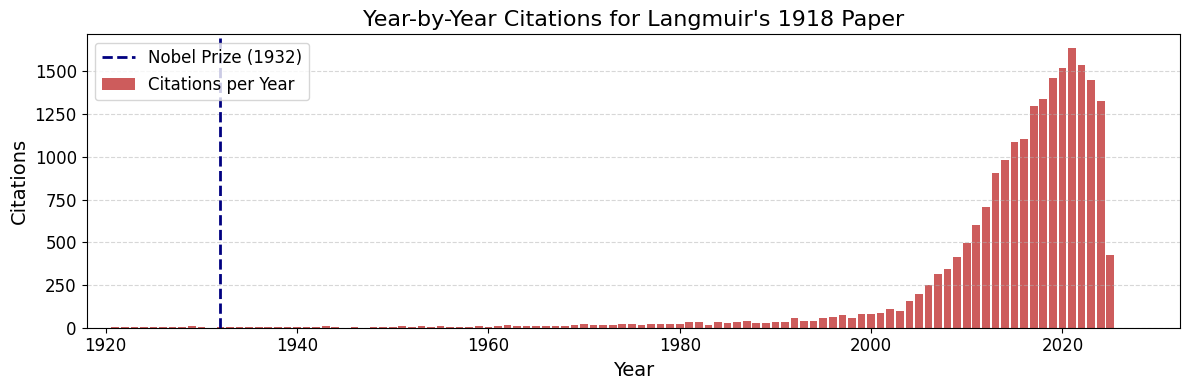

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("nobel_with_citations_cleaned.csv")

# Locate Langmuir's paper by WID
paper = df[df["Resolved_WID"] == "W1986113254"].iloc[0]

# Extract citation series
year_columns = sorted([col for col in df.columns if col.isdigit()], key=int)
citations = paper[year_columns].dropna().astype(int)

# Get Nobel and publication year
nobel_year = int(paper["Prize year"])
pub_year = int(paper["Pub year"])

# Create plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(citations.index.astype(int), citations.values, color='indianred', label="Citations per Year")
ax.axvline(nobel_year, color='navy', linestyle='--', linewidth=2, label=f"Nobel Prize ({nobel_year})")

ax.set_title("Year-by-Year Citations for Langmuir's 1918 Paper", fontsize=16)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Citations", fontsize=14)
ax.set_xlim(left=pub_year)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend(loc="upper left", frameon=True, fontsize=12)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

# Save high-res figure
fig.savefig("langmuir_1918_citations.png", dpi=300, bbox_inches='tight')
